In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from itertools import product
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller

In [ ]:
# Adım 0: Veriyi Yükleme
# data = pd.read_csv('data.csv')
data = pd.read_csv("data.csv", parse_dates=["date"], index_col="date").asfreq("D")
print(data)

            orders  temperature  media_spend
date                                        
2020-05-02      54    18.270322          0.0
2020-05-03      63    19.882444          0.0
2020-05-04      56    16.878095          0.0
2020-05-05      65    21.878648          0.0
2020-05-06      64    21.112398          0.0
...            ...          ...          ...
2022-06-26      89    12.669216          0.0
2022-06-27      77     9.819516          0.0
2022-06-28      97    18.834372          0.0
2022-06-29      80          NaN          0.0
2022-06-30      79    11.982388          0.0

[790 rows x 3 columns]


In [ ]:
# Adım 1: Veriyi Temizleme

data['temperature'].fillna(method='ffill', inplace=True)

# Belirleyeceğiniz eşik değeri
upper_threshold = 114 # Eşik değerini buraya yazın

# Eşik değeri üzerindeki değerleri forward fill ile doldurma
data['orders'] = data['orders'].apply(lambda x: x if x < upper_threshold else np.nan)
data['orders'].fillna(method='ffill', inplace=True)
print(data)

            orders  temperature  media_spend
date                                        
2020-05-02    54.0    18.270322          0.0
2020-05-03    63.0    19.882444          0.0
2020-05-04    56.0    16.878095          0.0
2020-05-05    65.0    21.878648          0.0
2020-05-06    64.0    21.112398          0.0
...            ...          ...          ...
2022-06-26    89.0    12.669216          0.0
2022-06-27    77.0     9.819516          0.0
2022-06-28    97.0    18.834372          0.0
2022-06-29    80.0    18.834372          0.0
2022-06-30    79.0    11.982388          0.0

[790 rows x 3 columns]


In [ ]:
# Mutlak değer sütunu oluşturma
data['temperature_abs'] = data['temperature'].abs()

# Ölçeklendirilmiş değer sütunu oluşturma
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data['temperature_scaled'] = scaler.fit_transform(data[['temperature']])

             temperature    orders  media_spend
temperature     1.000000  0.716545     0.009384
orders          0.716545  1.000000     0.248335
media_spend     0.009384  0.248335     1.000000


<Figure size 1000x600 with 0 Axes>

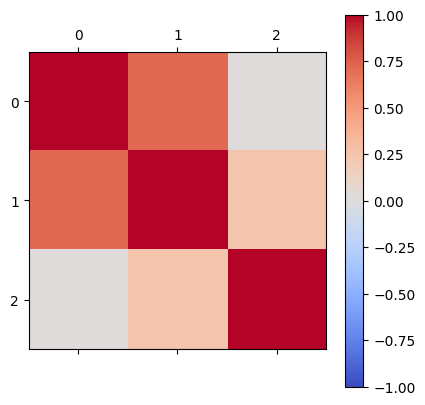

In [ ]:
# Adım 2: Korelasyon Kontrolü ve Grafiği
correlation_matrix = data[['temperature', 'orders', 'media_spend']].corr()
print(correlation_matrix)
plt.figure(figsize=(10, 6))
plt.matshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

In [ ]:
# Adım 3.1: Stationary Kontrolü ve Düzeltme
# ADF (Augmented Dickey-Fuller) testi ile durağanlık kontrolü
adf_result = adfuller(data['orders'].dropna())
print("ADF Test Statistics:", adf_result[0])
print("p-value:", adf_result[1])

# p-değeri kontrolü ve durağanlık değerlendirmesi
alpha = 0.05  # Belirlediğiniz anlamlılık seviyesi
if adf_result[1] <= alpha:
    print("Zaman serisi durağandır.")
else:
    print("Zaman serisi durağan değildir.")

ADF Test Statistics: -2.494134405803578
p-value: 0.11690801799140799
Zaman serisi durağan değildir.


In [ ]:
# Adım 3.2: Stationary Düzeltme
# 1. Veriyi günlük farklara dönüştürme
train_data = data.copy()  # Veriyi kopyalama
train_data['diff_orders'] = train_data['orders'].diff()

# 2. ADF (Augmented Dickey-Fuller) testi ile durağanlık kontrolü
adf_result = adfuller(train_data['diff_orders'].dropna())
print("ADF Test Statistics:", adf_result[0])
print("p-value:", adf_result[1])

# 3. Durağanlık elde etmek için gerekli fark alma derecesini belirleme
d = 1  # Örnek olarak

ADF Test Statistics: -9.123367703461511
p-value: 3.1611549868558107e-15


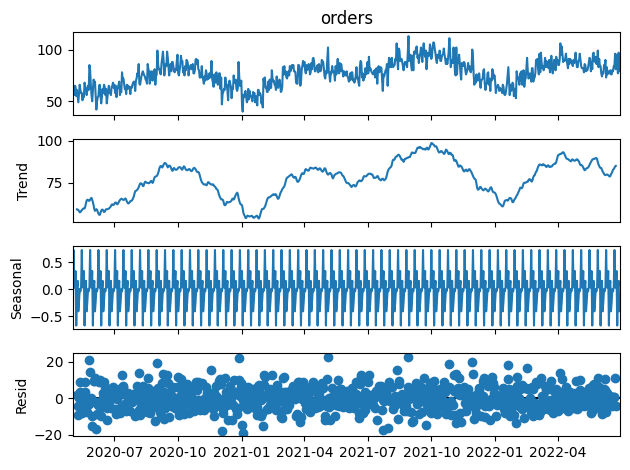

In [ ]:
# Adım 4.1: Mevsimsel Desen Kontrolü ve Grafik

y = data['orders']
data_y = seasonal_decompose(y, model="add", period=12)
data_plot = data_y.plot()
plt.show()

<Figure size 1200x600 with 0 Axes>

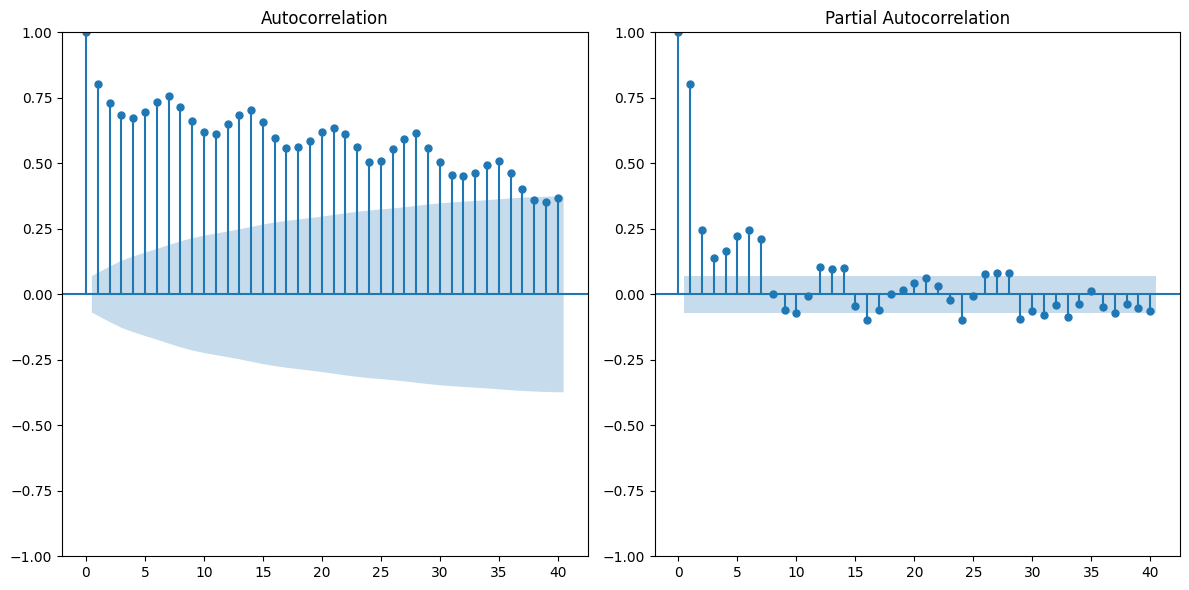

In [ ]:
# Adım 4.2: Mevsimsel Desen Kontrolü ve Grafik

plt.figure(figsize=(12, 6))

# Alt grafik düzeni oluşturma
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# ACF grafiği
plot_acf(train_data['orders'], lags=40, ax=axes[0])

# PACF grafiği
plot_pacf(train_data['orders'], lags=40, ax=axes[1])

plt.tight_layout()
plt.show()

In [ ]:
# Adım 5: Veriyi Train ve Test Olarak Bölme
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

In [ ]:
# Adım 6: Grid Search ile Parametre Hesaplama

from itertools import product
p_values = range(0, 3)
d_values = range(1, 2)
q_values = range(0, 3)
P_values = range(0, 3)
D_values = range(1, 2)
Q_values = range(0, 3)
s_values = [14]  # 14 günlük mevsimsel döngü örneği
param_combinations = product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values)

best_mse = float('inf')
best_params = None

for params in param_combinations:
    p, d, q, P, D, Q, s = params
    model = SARIMAX(train_data['orders'], order=(p, d, q), seasonal_order=(P, D, Q, s))
    results = model.fit(disp=False)
    predictions = results.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)
    mse = mean_squared_error(test_data['orders'], predictions)
    if mse < best_mse:
        best_mse = mse
        best_params = params

print("Best Parameters:", best_params)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py

Best Parameters: (2, 1, 0, 0, 1, 0, 14)


In [ ]:
# Adım 7: Modeli Eğitme ve Tahmin Yapma
p, d, q, P, D, Q, s = best_params  # En iyi parametreler
model = SARIMAX(data['orders'], exog=data[['temperature', 'media_spend']], order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit(disp=False)

In [ ]:
# Adım 8: Tahminlerin ve Gerçek Değerlerin hesaplanması
mondays = pd.date_range(start='2020-05-02', end='2022-06-26', freq='2W-MON')

forecast_df = pd.DataFrame(columns=['Date', 'Forecast', 'Lower_CI', 'Upper_CI'])

for monday in mondays:
    # Seçilen pazartesi tarihinden itibaren 2 haftalık tahmin aralığı oluşturuluyor
    forecast_period = pd.date_range(start=monday, periods=14, freq='D')
    forecast_period = forecast_period[forecast_period <= '2022-06-30']  # Adjust forecast period

    if forecast_period.empty:
        continue

    # Exog değerleri seçili pazartesi ve 2 haftalık tahmin aralığına göre belirleniyor
    exog_forecast = data.loc[forecast_period][['temperature', 'media_spend']]

    # Tahmin yapma
    forecast = results.get_forecast(steps=len(forecast_period), exog=exog_forecast)
    forecast_mean = forecast.predicted_mean
    forecast_conf_int = forecast.conf_int()

    # Tahmin sonuçlarını dataframe'e eklemek
    forecast_results = pd.DataFrame({
        'Date': forecast_period,
        'Forecast': forecast_mean,
        'Lower_CI': forecast_conf_int.iloc[:, 0],
        'Upper_CI': forecast_conf_int.iloc[:, 1]
    })

    forecast_df = forecast_df.append(forecast_results)

<ipython-input-339-7d811c9639d9>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append(forecast_results)
<ipython-input-339-7d811c9639d9>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append(forecast_results)
<ipython-input-339-7d811c9639d9>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append(forecast_results)
<ipython-input-339-7d811c9639d9>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append(forecast_results)
<ipython-input-339-7d811c9639d9>:30: FutureWarning: The frame.append method is deprecated and will be remove

In [ ]:
# Adım 9: Tahminlerin ve Gerçek Değerlerin Karşılaştırılması
# Tahmin yap
exog_test_data = test_data[['temperature', 'media_spend']]
predictions = results.get_prediction(start=len(train_data), end=len(train_data) + len(test_data) - 1, exog=exog_test_data)
predictions_mean = predictions.predicted_mean

# Gerçek ve tahmin edilen değerleri bir veri çerçevesinde birleştir
results_df = pd.DataFrame({'Date': test_data.index, 'Actual': test_data['orders'], 'Predicted': predictions_mean})
print(results_df)

                 Date  Actual  Predicted
date                                    
2022-01-24 2022-01-24    60.0  65.306754
2022-01-25 2022-01-25    61.0  60.719353
2022-01-26 2022-01-26    68.0  65.748435
2022-01-27 2022-01-27    67.0  64.840041
2022-01-28 2022-01-28    55.0  55.121699
...               ...     ...        ...
2022-06-26 2022-06-26    89.0  81.081803
2022-06-27 2022-06-27    77.0  85.461160
2022-06-28 2022-06-28    97.0  92.895184
2022-06-29 2022-06-29    80.0  93.779057
2022-06-30 2022-06-30    79.0  82.457354

[158 rows x 3 columns]


In [ ]:
# Adım 10: Metrik Değerlerin Hesaplanması
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(test_data['orders'], predictions_mean)
mse = mean_squared_error(test_data['orders'], predictions_mean)
rmse = np.sqrt(mse)

print('Mean Absolute Error (MAE):', mae)
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)

Mean Absolute Error (MAE): 4.211543402023831
Mean Squared Error (MSE): 28.558366114382693
Root Mean Squared Error (RMSE): 5.344002817587458


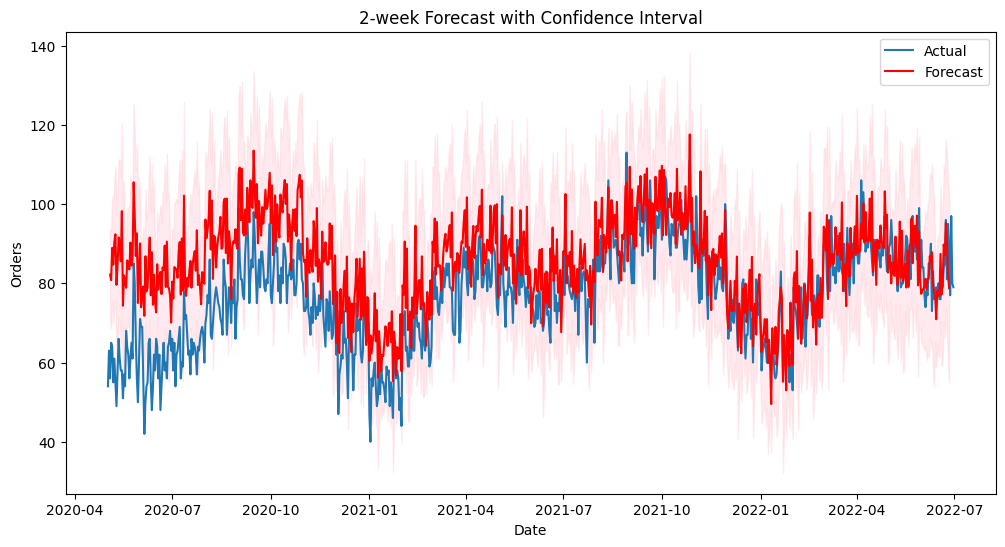

In [ ]:
# Adım 11: Tahminlerin ve Güven Aralığının Görselleştirilmesi
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['orders'], label='Actual')
plt.plot(forecast_df['Date'], forecast_df['Forecast'], label='Forecast', color='red')
plt.fill_between(forecast_df['Date'], forecast_df['Lower_CI'], forecast_df['Upper_CI'], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Orders')
plt.title('2-week Forecast with Confidence Interval')
plt.legend()
plt.show()

In [ ]:
# # Modelin teşhis grafiğini çizdirme
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#
# residuals = test_data['orders'] - predictions_mean
# fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# plot_acf(residuals, lags=20, ax=axes[0])
# plot_pacf(residuals, lags=20, ax=axes[1])
# plt.show()

In [ ]:
# Streamlit
import streamlit as st
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Streamlit uygulamasının başlığı
st.title('Tahmin Uygulaması')

# Model eğitimi ve tahmin fonksiyonları (Daha önce yazdığınız kodları buraya ekleyin)

# Örnek veriyi yükleyin veya gerçek veriyi yükleyin
data = pd.read_csv("data.csv", parse_dates=["date"], index_col="date").asfreq("D")
train_data = data['train']
exog_train = data[['temperature', 'media_spend']]

# Modeli eğit
model = train_model(train_data, exog_train)

# Streamlit arayüzü
st.sidebar.header('Parametreler')
start_date = st.sidebar.date_input('Başlangıç Tarihi', value=data.index.min())
end_date = st.sidebar.date_input('Bitiş Tarihi', value=data.index.max())
forecast_button = st.sidebar.button('Tahmin Yap')

if forecast_button:
    st.subheader('Tahmin Sonuçları')
    forecast_period = pd.date_range(start=start_date, end=end_date, freq='D')

    # Exog değerleri belirle (örnek olarak)
    exog_forecast = data.loc[forecast_period][['temperature', 'media_spend']]

    # Tahmin yap
    forecasted_values = make_forecast(model, exog_forecast, forecast_period)

    # Tahmin sonuçlarını göster
    st.write(forecasted_values)

In [ ]:
!pip install flask

In [ ]:
from flask import Flask, request, jsonify
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler

app = Flask(__name__)

# Model eğitimi ve tahmin fonksiyonları
def train_model(train_data, exog_train):
    # Model parametrelerini belirleme
    p = 2  # Örnek: AR(p)
    d = 1  # Örnek: I(d)
    q = 0  # Örnek: MA(q)
    P = 0  # Örnek: Seasonal AR(P)
    D = 1  # Örnek: Seasonal I(D)
    Q = 0  # Örnek: Seasonal MA(Q)
    s = 14  # Örnek: Sezonun uzunluğu (haftada kaç gözlem)

    # SARIMA modelini oluşturma
    model = SARIMAX(train_data, exog=exog_train, order=(p, d, q), seasonal_order=(P, D, Q, s))

    # Modeli eğitme
    trained_model = model.fit(disp=False)

    return trained_model

def make_forecast(model, exog_forecast, forecast_period):
    # Tahmin yapılacak
    forecast = model.get_forecast(steps=len(forecast_period), exog=exog_forecast)
    forecasted_values = forecast.predicted_mean
    forecast_conf_int = forecast.conf_int()

    # Tahmin sonuçlarını bir DataFrame olarak döndür
    forecast_df = pd.DataFrame({
        'Date': forecast_period,
        'Forecast': forecasted_values,
        'Lower_CI': forecast_conf_int.iloc[:, 0],
        'Upper_CI': forecast_conf_int.iloc[:, 1]
    })

    return forecast_df

# Örnek veri (örnek veriyi modelinizi eğitmek için gerçek verinizle değiştirin)
data = pd.read_csv("data.csv", parse_dates=["date"], index_col="date").asfreq("D")

# Veriyi temizleme
data['temperature'].fillna(method='ffill', inplace=True)
upper_threshold = 114
data['orders'] = data['orders'].apply(lambda x: x if x < upper_threshold else np.nan)
data['orders'].fillna(method='ffill', inplace=True)
data['temperature_abs'] = data['temperature'].abs()

# Ölçeklendirilmiş değer sütunu oluşturma
scaler = StandardScaler()
data['temperature_scaled'] = scaler.fit_transform(data[['temperature']])

train_data = data['orders']
exog_train = data[['temperature_scaled', 'media_spend']]

# Modeli eğit
model = train_model(train_data, exog_train)

@app.route('/forecast', methods=['GET'])
def forecast():
    start_date = request.args.get('start_date')
    end_date = request.args.get('end_date')
    forecast_period = pd.date_range(start=start_date, end=end_date, freq='D')

    # Exog değerleri belirle (örnek olarak)
    exog_forecast = data.loc[forecast_period][['temperature_scaled', 'media_spend']]

    # Tahmin yap
    forecasted_values = make_forecast(model, exog_forecast, forecast_period)

    result = {
        'forecast_period': forecast_period.strftime('%Y-%m-%d'),
        'forecast_values': forecasted_values.to_dict(orient='records')
    }
    return jsonify(result)

if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
